In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from datetime import datetime
import os
import dill

In [3]:
# Define the selected features for each ticker
selected_features = {
    'BND_enrich.csv': ["3day MA", "Returns", "DGS10", "10day MA", "breakeven_rate", "VIXCLS", "month", "DFII10", "day", "IRLTLT01USM156N", "EMVMACROBUS", "Std_dev", "EMVOVERALLEMV", "CPALTT01USM661S", "PAYEMS", "EMVMACROINTEREST", "RBUSBIS"],
    'GLD_enrich.csv': ["Returns", "3day MA", "day", "Std_dev", "10day MA", "O-C", "month", "Volume", "EMVMACROINTEREST", "WALCL", "FEDFUNDS", "VIXCLS", "DGS3MO", "DGS10", "EMVMACROBUS", "PAYEMS", "CPALTT01USM661S", "EMVOVERALLEMV", "VOL", "year", "H-L", "GDPC1", "DFII10", "IRLTLT01USM156N", "RBUSBIS", "breakeven_rate", "Buy_Sell", "Buy_Sell_on_Open", "Increase_Decrease"],
    'GOVT_enrich.csv': ["3day MA", "DGS10", "breakeven_rate", "DGS2", "Returns", "DFII10", "EMVOVERALLEMV", "IRLTLT01USM156N", "month", "CPALTT01USM661S", "Std_dev", "PAYEMS", "VIXCLS"],
    'IVOO_enrich.csv': ["VIXCLS", "3day MA", "Returns", "month", "10day MA", "O-C", "EMVOVERALLEMV", "VOL", "WALCL", "CPALTT01USM661S", "Std_dev", "EMVMACROINTEREST", "DFII10", "day", "GDPC1", "year", "EMVMACROBUS", "IRLTLT01USM156N", "DGS10", "PAYEMS", "DGS3MO", "breakeven_rate", "Volume", "Buy_Sell_on_Open", "H-L"],
    'JNK_enrich.csv': ["3day MA", "Returns", "VIXCLS", "10day MA", "month", "O-C", "EMVOVERALLEMV", "breakeven_rate", "Std_dev", "VOL", "EMVMACROINTEREST", "GDPC1", "EMVMACROBUS", "IRLTLT01USM156N", "CPALTT01USM661S", "day", "DFII10", "DGS10", "PAYEMS", "DGS3MO", "Volume"],
    'SPY_enrich.csv': ["Returns", "VIXCLS", "month", "O-C", "10day MA", "Volume", "VOL", "CPALTT01USM661S", "day", "EMVOVERALLEMV", "WALCL", "EMVMACROINTEREST", "breakeven_rate", "GDPC1"],
    'VIOO_enrich.csv': ["Returns", "VIXCLS", "3day MA", "O-C", "10day MA", "month", "CPALTT01USM661S", "GDPC1", "DGS3MO", "Std_dev", "DFII10", "day", "IRLTLT01USM156N", "PAYEMS", "EMVOVERALLEMV", "VOL", "year", "H-L", "EMVMACROINTEREST", "EMVMACROBUS", "FEDFUNDS", "WALCL", "Buy_Sell_on_Open", "DGS2", "breakeven_rate"],
    'VOO_enrich.csv': ["3day MA", "VIXCLS", "Returns", "month", "10day MA", "O-C", "VOL", "CPALTT01USM661S", "GDPC1", "DGS3MO", "EMVMACROINTEREST", "day", "DFII10", "IRLTLT01USM156N", "EMVMACROBUS", "H-L", "FEDFUNDS"]
}

# Manually set which ticker to work on
ticker = 'BND_enrich.csv'  # Replace with the desired ticker file name

np.random.seed(2023)
print(f"Processing ticker: {ticker}")



Processing ticker: BND_enrich.csv


In [4]:
# Read stock_data csv
stock_data = pd.read_csv(ticker)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
# stock_data = stock_data.drop(columns=['Adj.Close'])

# Daily Volatility % (VOL)
stock_data['VOL'] = (stock_data['High'] - stock_data['Low']) / stock_data['Open'] * 100
stock_data = stock_data.drop(columns=['Open', 'High', 'Low'])

# Drop columns with any NA values
stock_data = stock_data.dropna(axis=1)

# Select predefined features for the current ticker
features = selected_features[ticker]

# Create a new dataset with the selected features
newdata = stock_data[['Date'] + features + ['Close']]

# Split new data into training and testing sets
split_point = len(stock_data) - 90           # Last 90 days for testing
xr_train = newdata.iloc[:split_point, 1:-1]  # Exclude Date and Close
xr_test = newdata.iloc[split_point:, 1:-1]   # Exclude Date and Close
yr_train = newdata.iloc[:split_point, -1]    # Close
yr_test = newdata.iloc[split_point:, -1]     # Close

# Feature scaling including Close (target variable)
scaler = StandardScaler()
xr_train_scaled = pd.DataFrame(scaler.fit_transform(xr_train), columns=xr_train.columns)
xr_test_scaled = pd.DataFrame(scaler.transform(xr_test), columns=xr_test.columns)

yr_train_scaled = scaler.fit_transform(yr_train.values.reshape(-1, 1)).flatten()
yr_test_scaled = scaler.transform(yr_test.values.reshape(-1, 1)).flatten()

scaling_params = {'mean': scaler.mean_, 'scale': scaler.scale_}  # Store the scaling parameters

# Function to unscale values
def unscale_values(scaled_values, scaling_params):
    unscaled_values = scaled_values * scaling_params['scale'][-1] + scaling_params['mean'][-1]
    return unscaled_values

In [5]:
from sklearn.model_selection import GridSearchCV
# Hyperparameter tuning for SVM using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'epsilon': [0.1, 0.2, 0.5, 0.3]
}
np.random.seed(2024)
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(xr_train_scaled, yr_train_scaled)

# Extract the best model after grid search
final_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated score: {-grid_search.best_score_}")

Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 0.001}
Best cross-validated score: 0.019065332397052433


In [6]:
np.random.seed(2023)
# Train data performance (Unscaled)
train_preds_scaled = final_model.predict(xr_train_scaled)
train_preds = unscale_values(train_preds_scaled, scaling_params)
train_rmse = np.sqrt(mean_squared_error(yr_train, train_preds))
train_mape = mean_absolute_percentage_error(yr_train, train_preds)
print(f"Train performance for {ticker} - RMSE: {train_rmse}, MAPE: {train_mape}")

# Test data performance (Unscaled)
test_preds_scaled = final_model.predict(xr_test_scaled)
test_preds = unscale_values(test_preds_scaled, scaling_params)
test_rmse = np.sqrt(mean_squared_error(yr_test, test_preds))
test_mape = mean_absolute_percentage_error(yr_test, test_preds)
print(f"Test performance for {ticker} - RMSE: {test_rmse}, MAPE: {test_mape}")

# Plot using unscaled values
plt.figure(figsize=(6, 6))
plt.plot(newdata['Date'].iloc[split_point:], yr_test, color='black', lw=2, label='Actual')
plt.plot(newdata['Date'].iloc[split_point:], test_preds, color='red', lw=2, label='Predicted')
plt.scatter(newdata['Date'].iloc[split_point:], yr_test, color='black', s=10)
plt.scatter(newdata['Date'].iloc[split_point:], test_preds, color='red', s=10)
plt.xticks(rotation=45)
plt.title(f'Test Performance for {ticker}')
plt.xlabel('')
plt.ylabel('Closing Price')
plt.legend()
plt.tight_layout()
plot_filename = f'{os.path.splitext(ticker)[0]}_performance_plot.png'
plt.savefig(plot_filename)
plt.close()

Train performance for BND_enrich.csv - RMSE: 0.1796775227780969, MAPE: 0.0017401401757038333
Test performance for BND_enrich.csv - RMSE: 0.38558339848667134, MAPE: 0.004770730003299112


100%|█████████████████████████████████████| 3456/3456 [3:32:11<00:00,  3.68s/it]


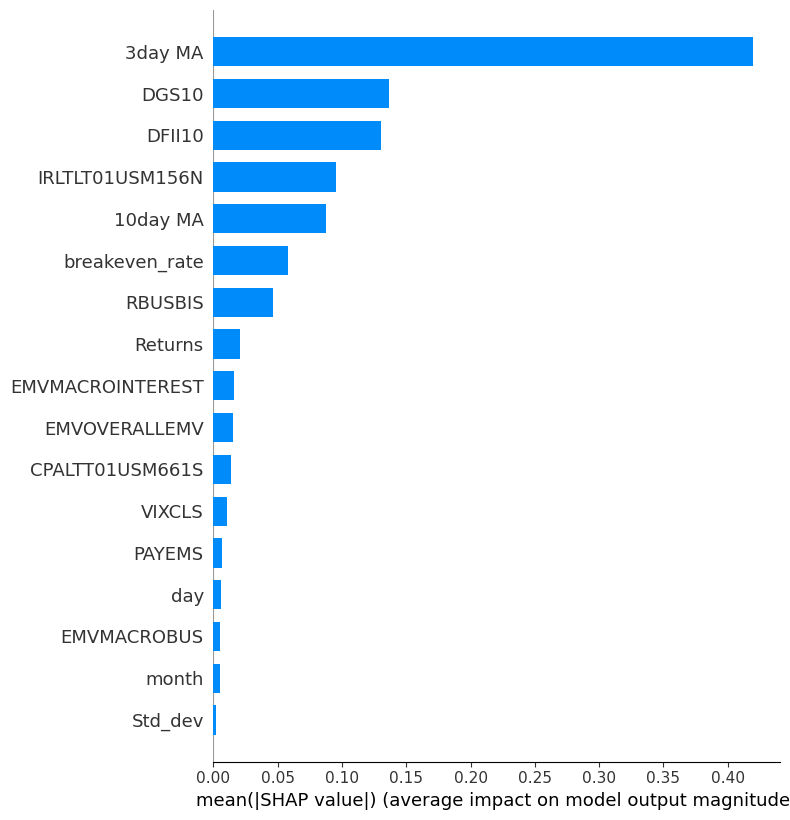

In [8]:
import shap

# Sample a subset of the training data for the SHAP explainer
background_sample = shap.sample(xr_train_scaled, 100)  # Adjust the sample size as needed

# Create a SHAP explainer with the reduced background data
explainer = shap.KernelExplainer(final_model.predict, background_sample)

# Compute SHAP values for the full dataset
shap_values = explainer.shap_values(xr_train_scaled)

# Plot SHAP summary
shap.summary_plot(shap_values, xr_train_scaled, plot_type="bar", feature_names=xr_train_scaled.columns)

In [19]:
tickers = list(selected_features.keys())

for ticker in tickers:
    print(f"Processing ticker: {ticker}")
    # Read stock_data csv
    stock_data = pd.read_csv(ticker)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    # stock_data = stock_data.drop(columns=['Adj.Close'])

    # Daily Volatility % (VOL)
    stock_data['VOL'] = (stock_data['High'] - stock_data['Low']) / stock_data['Open'] * 100
    stock_data = stock_data.drop(columns=['Open', 'High', 'Low'])

    # Drop columns with any NA values
    stock_data = stock_data.dropna(axis=1)

    # Select predefined features for the current ticker
    features = selected_features[ticker]

    # Create a new dataset with the selected features
    newdata = stock_data[['Date'] + features + ['Close']]

    # Split new data into training and testing sets
    split_point = len(stock_data) - 90           # Last 90 days for testing
    xr_train = newdata.iloc[:split_point, 1:-1]  # Exclude Date and Close
    xr_test = newdata.iloc[split_point:, 1:-1]   # Exclude Date and Close
    yr_train = newdata.iloc[:split_point, -1]    # Close
    yr_test = newdata.iloc[split_point:, -1]     # Close

    # Feature scaling including Close (target variable)
    scaler = StandardScaler()
    xr_train_scaled = pd.DataFrame(scaler.fit_transform(xr_train), columns=xr_train.columns)
    xr_test_scaled = pd.DataFrame(scaler.transform(xr_test), columns=xr_test.columns)

    yr_train_scaled = scaler.fit_transform(yr_train.values.reshape(-1, 1)).flatten()
    yr_test_scaled = scaler.transform(yr_test.values.reshape(-1, 1)).flatten()

    scaling_params = {'mean': scaler.mean_, 'scale': scaler.scale_}  # Store the scaling parameters

    # Function to unscale values
    def unscale_values(scaled_values, scaling_params):
        unscaled_values = scaled_values * scaling_params['scale'][-1] + scaling_params['mean'][-1]
        return unscaled_values
    # Hyperparameter tuning for SVM using GridSearchCV
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'epsilon': [0.1, 0.2, 0.5, 0.3]
    }
    np.random.seed(2024)
    svr = SVR()
    grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(xr_train_scaled, yr_train_scaled)

    # Extract the best model after grid search
    final_model = grid_search.best_estimator_

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validated score: {-grid_search.best_score_}")
    
    np.random.seed(2023)
    # Train data performance (Unscaled)
    train_preds_scaled = final_model.predict(xr_train_scaled)
    train_preds = unscale_values(train_preds_scaled, scaling_params)
    train_rmse = np.sqrt(mean_squared_error(yr_train, train_preds))
    train_mape = mean_absolute_percentage_error(yr_train, train_preds)
    print(f"Train performance for {ticker} - RMSE: {train_rmse}, MAPE: {train_mape}")

    # Test data performance (Unscaled)
    test_preds_scaled = final_model.predict(xr_test_scaled)
    test_preds = unscale_values(test_preds_scaled, scaling_params)
    test_rmse = np.sqrt(mean_squared_error(yr_test, test_preds))
    test_mape = mean_absolute_percentage_error(yr_test, test_preds)
    print(f"Test performance for {ticker} - RMSE: {test_rmse}, MAPE: {test_mape}")

    # Plot using unscaled values
    plt.figure(figsize=(6, 6))
    plt.plot(newdata['Date'].iloc[split_point:], yr_test, color='black', lw=2, label='Actual')
    plt.plot(newdata['Date'].iloc[split_point:], test_preds, color='red', lw=2, label='Predicted')
    plt.scatter(newdata['Date'].iloc[split_point:], yr_test, color='black', s=10)
    plt.scatter(newdata['Date'].iloc[split_point:], test_preds, color='red', s=10)
    plt.xticks(rotation=45)
    plt.title(f'Test Performance for {ticker}')
    plt.xlabel('')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.tight_layout()
    plot_filename = f'{os.path.splitext(ticker)[0]}_performance_plot.png'
    plt.savefig(plot_filename)
    plt.close()
    

Processing ticker: BND_enrich.csv
Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 0.001}
Best cross-validated score: 0.019065332397052333
Train performance for BND_enrich.csv - RMSE: 0.17967752277809626, MAPE: 0.0017401401757037875
Test performance for BND_enrich.csv - RMSE: 0.3855833984866786, MAPE: 0.004770730003299159
Saved environment for BND_enrich.csv as environment_BND_enrich.pkl
Processing ticker: GLD_enrich.csv
Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 0.001}
Best cross-validated score: 0.007309951267799783
Train performance for GLD_enrich.csv - RMSE: 1.1297430052736392, MAPE: 0.006257450258541585
Test performance for GLD_enrich.csv - RMSE: 2.8685890392976825, MAPE: 0.010195737697191239
Saved environment for GLD_enrich.csv as environment_GLD_enrich.pkl
Processing ticker: GOVT_enrich.csv
Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 0.001}
Best cross-validated score: 0.11179724426222089
Train performance for GOVT_enrich.csv - RMSE: 0.054928654313153656, M

In [ ]:
import dill

# Load the environment for a specific ticker
ticker = 'BND_enrich.csv'  # Example
environment_filename = f"environment_{os.path.splitext(ticker)[0]}.pkl"

with open(environment_filename, 'rb') as file:
    dill.load_session(file)

# Now, all your variables and models related to this ticker are restored
